# Spaceship Titanic
#### (What could go wrong)
## Charles Fearn

In [41]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from math import ceil
from scipy import linalg
from IPython.display import Image
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from math import ceil
from scipy import linalg
from IPython.display import Image
from IPython.display import display
from sklearn import metrics
from sklearn.metrics import classification_report

In [42]:
#Load train and test datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


# Data Analysis

  Here we are doing an initial explortation and analysis of the training dataset, so we can get an understanding of our data's structure. 'train.info() gives us a quick summary of the data we are using. we will also take a look at statistical data for our numerical feature values.
  
  By using,

   for column in train.select_dtypes(include=['object']).columns:
    print(f"\n{column}: {train[column].unique()}")

  we loop over the categorical columns in the dataset, printing unique values for each. It offers a glimpse into the variety and range of categorical data, aiding in feature engineering decisions.

  overall, this section helps us understand the data and find potential challenges that we might need to take care of before we continue.

In [43]:
# look at information about the train dataset
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


In [44]:
#Display null values in the train dataset
print(train.isnull().sum())

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [45]:
#Show statistical summary of numerical features in the train dataset
print(train[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].describe())

               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000  


In [46]:
#Display data types in the train dataset
print(train.dtypes)

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


In [47]:
#Display unique values in categorical features of the train dataset
for column in train.select_dtypes(include=['object']).columns:
    print(f"\n{column}: {train[column].unique()}")



PassengerId: ['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']

HomePlanet: ['Europa' 'Earth' 'Mars' nan]

CryoSleep: [False True nan]

Cabin: ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']

Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]

VIP: [False True nan]

Name: ['Maham Ofracculy' 'Juanna Vines' 'Altark Susent' ... 'Fayey Connon'
 'Celeon Hontichre' 'Propsh Hontichre']


###Data Cleaning(Handling missing values)

Here, we are just wranggling the data, or cleaning the data, making it easier for us to use.

In [48]:
# Split numerical and categorical columns
numerical_cols = train.select_dtypes(include=['float64']).columns
categorical_cols = train.select_dtypes(include=['object']).columns


In [49]:
# fill numerical columns with median
numerical_imputer = SimpleImputer(strategy='median')
train[numerical_cols] = numerical_imputer.fit_transform(train[numerical_cols])


In [50]:
# fill categorical columns with the most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
train[categorical_cols] = categorical_imputer.fit_transform(train[categorical_cols])

### Feature Engineering


In [51]:
#information from the 'Name' column
train['Title'] = train['Name'].apply(lambda x: x.split(' ')[1])
train['Title'] = train['Title'].apply(lambda x: 'Rare' if x not in ['Mr.', 'Mrs.', 'Miss.', 'Master.'] else x)


# Visualize relationships in the data for numerical columns

In this section, we are creating a correlation heatmap to visually explore the relationships between numerical features in the training dataset

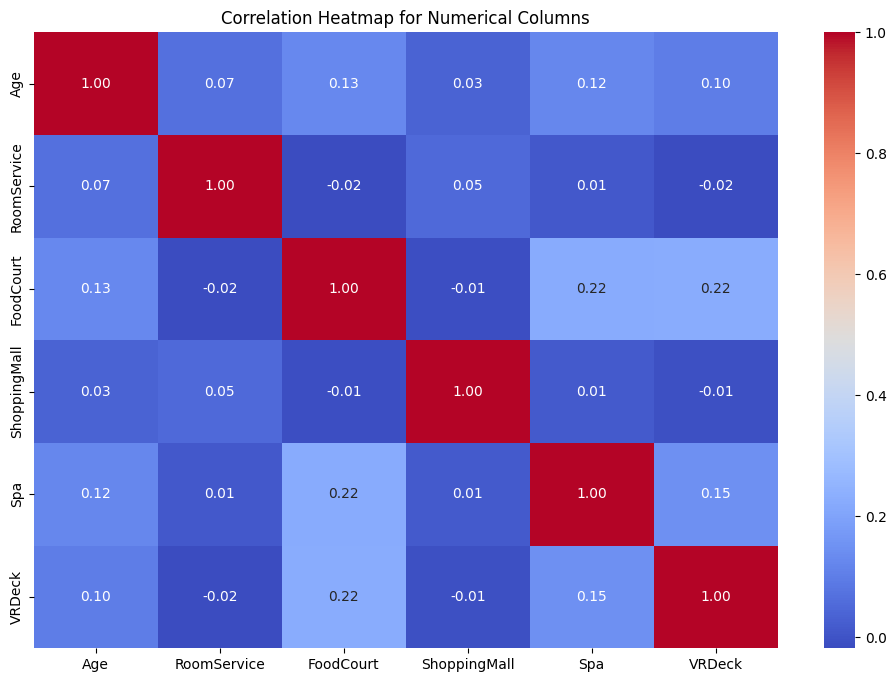

In [52]:
# List of numerical features
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


plt.figure(figsize=(12, 8))
sns.heatmap(train[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Numerical Columns')
plt.show()


# Model Building

Now we need to prepare the data for training a ML model

In [53]:
#Define features and target variable
X = train.drop(['PassengerId', 'Name', 'Transported'], axis=1)
y = train['Transported']

#Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
#Preprocessing for numerical and categorical data
numerical_features = X.select_dtypes(include=['float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [55]:
#Define the model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

In [56]:
#Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])

# Model Evaluation

performing cross-validation to assess the model's performance before making predictions on the validation set.

In [57]:
#Evaluate the model using cross-validation
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {np.mean(scores)}")


Cross-Validation Accuracy: 0.7901788059881246


In [58]:
#Fit model
#Evaluate the model using cross-validation
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Title'], dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [59]:
#Predictions on validation set
y_pred_valid = clf.predict(X_valid)

# Calculate accuracy on the validation set

In [60]:
accuracy = accuracy_score(y_valid, y_pred_valid)
print(f"\nValidation Set Accuracy: {accuracy}")


Validation Set Accuracy: 0.7878090856814262


In [61]:
#Feature Importance
feature_importance = clf.named_steps['model'].feature_importances_
categorical_features_names = clf.named_steps['preprocessor'].transformers_[1][1]\
                              .named_steps['onehot'].get_feature_names_out(input_features=categorical_features)
features = numerical_features.tolist() + categorical_features_names.tolist()
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)


#  predictions on the test set

In [62]:
# Use the same imputers to transform the test data
test[numerical_cols] = numerical_imputer.transform(test[numerical_cols])
test[categorical_cols] = categorical_imputer.transform(test[categorical_cols])

# Now you can proceed with the rest of your code
test_data_imputed = test.drop(['PassengerId', 'Name'], axis=1)


In [63]:
# Feature Engineering for Test Data
test['Title'] = test['Name'].apply(lambda x: x.split(' ')[1])
test['Title'] = test['Title'].apply(lambda x: 'Rare' if x not in ['Mr.', 'Mrs.', 'Miss.', 'Master.'] else x)

In [64]:
# Define features for test data
X_test = test.drop(['PassengerId', 'Name'], axis=1)



In [65]:
test_predictions = clf.predict(X_test)

In [66]:
results = pd.DataFrame({'PassengerId': test['PassengerId'], 'Transported': test_predictions})


In [67]:
results

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


# Logistic Regression

In [68]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
print("Full train dataset shape is {}".format(train.shape))

Full train dataset shape is (8693, 14)


## Data Handling

The following section deals with hadling the data from the dataset. For every categorical variable dummies were generated to allow for mathmatical manipulation. Homeplanet, Destination, Cryosleep, and VIP variables were dummified initially. I got rid of the redundant false columns (This does assue null values to be false, but VIP and CryoSleep would likely have detailed dossiers of clients making this feasible in my opinion.) Cabin was split in three: Deck, CabinNumber, and side. Deck and side were also dummified. Age was the one instance where filling na's with 0 was not justifiable. I therefore took the average age and filled the Na's with it. Names and Passenger ID were dropped as they were not neccessary for Logisctic analysis.


In [69]:
# initial dummies and cleanup
train = pd.get_dummies(data = train,columns = ['HomePlanet'])
train = pd.get_dummies(data = train,columns = ['Destination'])
train = pd.get_dummies(data = train,columns = ['CryoSleep'])
train = pd.get_dummies(data = train,columns = ['VIP'])
train=train.drop(['CryoSleep_False','VIP_False'],1)

#Cabin split and cleanup
train[['Deck','CabinNumber','Side']] = train['Cabin'].str.split('/',expand=True)
train=train.drop(['Cabin'],axis=1)

# Fill na's with average Age
train[['Age']]=train[['Age']].fillna(train[['Age']].mean())

# Removed Name and id as they were not used
train=train.drop(['PassengerId','Name'],1)
train[['Transported']] = train[['Transported']].astype(int)

#Got dummies for Deck and Side
train = pd.get_dummies(data = train,columns = ['Deck'])
train = pd.get_dummies(data = train,columns = ['Side'])

# Fill remaining na's with 0 convert cabin number to int
train=train.fillna(0)
train[['CabinNumber']] = train[['CabinNumber']].astype(int)

<ipython-input-69-b0646f862439>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train=train.drop(['CryoSleep_False','VIP_False'],1)
<ipython-input-69-b0646f862439>:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train=train.drop(['PassengerId','Name'],1)


In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        8693 non-null   float64
 1   RoomService                8693 non-null   float64
 2   FoodCourt                  8693 non-null   float64
 3   ShoppingMall               8693 non-null   float64
 4   Spa                        8693 non-null   float64
 5   VRDeck                     8693 non-null   float64
 6   Transported                8693 non-null   int64  
 7   HomePlanet_Earth           8693 non-null   uint8  
 8   HomePlanet_Europa          8693 non-null   uint8  
 9   HomePlanet_Mars            8693 non-null   uint8  
 10  Destination_55 Cancri e    8693 non-null   uint8  
 11  Destination_PSO J318.5-22  8693 non-null   uint8  
 12  Destination_TRAPPIST-1e    8693 non-null   uint8  
 13  CryoSleep_True             8693 non-null   uint8

## Data Categorization

This Section breaks the data off into very rough categories to try and sift through the data. I came up with six broad categories: Basic, Spending, Origin, Dest, Luxury, and Deck. This created 6 different test sets on which to run logistic regressions.

In [71]:
# XBasic XSpending XOrigin XDest XLuxury XDeck
XBasic=train[['Age','CabinNumber']]
XSpending=train[['RoomService','FoodCourt' ,'ShoppingMall','Spa','VRDeck']]
XOrigin=train[['HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars']]
XDest=train[['Destination_55 Cancri e','Destination_PSO J318.5-22','Destination_TRAPPIST-1e']]
XLuxury=train[['CryoSleep_True','VIP_True']]
XDeck=train[['Deck_A','Deck_B','Deck_C','Deck_D','Deck_E','Deck_F','Deck_G','Deck_T','Side_P','Side_S']]
y=train['Transported']
XBasic_train, XBasic_test, yBasic_train, yBasic_test = train_test_split(XBasic, y, test_size=0.2)
XSpending_train, XSpending_test, ySpending_train, ySpending_test = train_test_split(XSpending, y, test_size=0.2)
XOrigin_train, XOrigin_test, yOrigin_train, yOrigin_test = train_test_split(XOrigin, y, test_size=0.2)
XDest_train, XDest_test, yDest_train, yDest_test = train_test_split(XDest, y, test_size=0.2)
XLuxury_train, XLuxury_test, yLuxury_train, yLuxury_test = train_test_split(XLuxury, y, test_size=0.2)
XDeck_train, XDeck_test, yDeck_train, yDeck_test = train_test_split(XDeck, y, test_size=0.2)


## Basic Category

The Basic Category contains age and cabin number. Primarily due to lack of better category. The confusion matrix below summarises the results. This Category provided very middling results. An accuracy of 53% was achieved. not much better than guessing.


                 precision    recall  f1-score   support

Not Transported       0.54      0.42      0.47       887
    Transported       0.51      0.62      0.56       852

       accuracy                           0.52      1739
      macro avg       0.52      0.52      0.51      1739
   weighted avg       0.52      0.52      0.51      1739



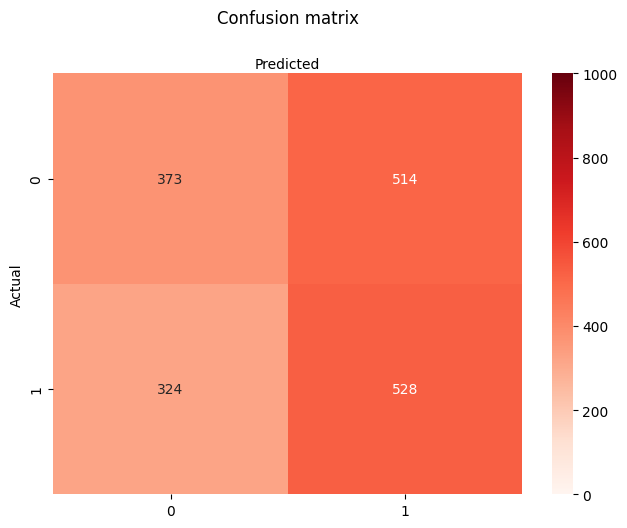

In [72]:
modelBasic = LogisticRegression(random_state=16)
modelBasic.fit(XBasic_train, yBasic_train)
y_predBasic = modelBasic.predict(XBasic_test)

cnf_matrix_basic = metrics.confusion_matrix(yBasic_test, y_predBasic)
cnf_matrix_basic

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_basic), annot=True, cmap="Reds" ,fmt='g',vmin=0, vmax=1000)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

target_names = ['Not Transported', 'Transported']
print(classification_report(yBasic_test, y_predBasic, target_names=target_names))

## Spending Category

This section deals with the Spending category. Basically any money spent on ship services was in this category. This was of the best sets, achieving an accuracy of 75%

                 precision    recall  f1-score   support

Not Transported       0.86      0.65      0.74       847
    Transported       0.73      0.90      0.81       892

       accuracy                           0.78      1739
      macro avg       0.80      0.78      0.78      1739
   weighted avg       0.80      0.78      0.78      1739



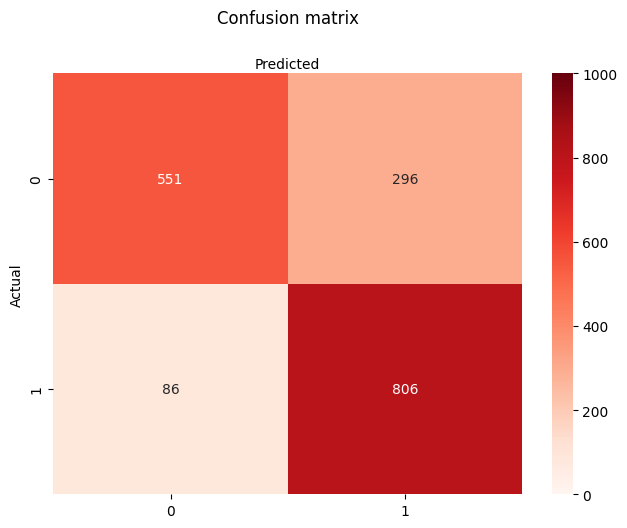

In [73]:
modelSpending = LogisticRegression(random_state=16)
modelSpending.fit(XSpending_train, ySpending_train)
y_predSpending = modelSpending.predict(XSpending_test)

cnf_matrix_Spending = metrics.confusion_matrix(ySpending_test, y_predSpending)
cnf_matrix_Spending

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_Spending), annot=True, cmap="Reds" ,fmt='g',vmin=0, vmax=1000)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

target_names = ['Not Transported', 'Transported']
print(classification_report(ySpending_test, y_predSpending, target_names=target_names))

## Planet Origin Category

This section shows that the home planets had very low indication of transportaion or not. Accuracy of only 58%


                 precision    recall  f1-score   support

Not Transported       0.56      0.63      0.60       866
    Transported       0.58      0.52      0.55       873

       accuracy                           0.57      1739
      macro avg       0.57      0.57      0.57      1739
   weighted avg       0.57      0.57      0.57      1739



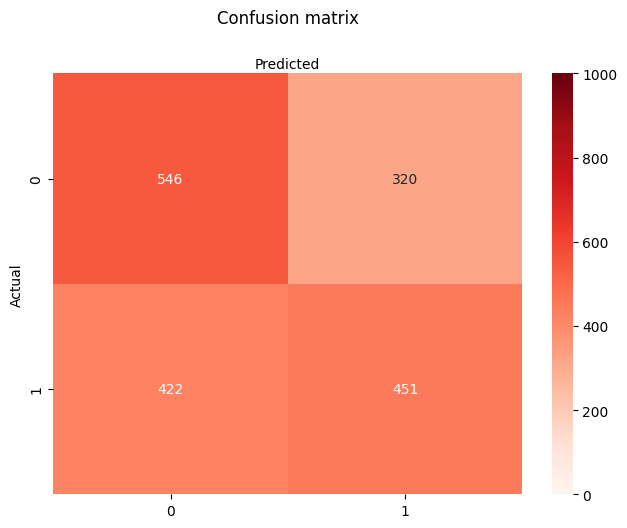

In [74]:
modelOrigin = LogisticRegression(random_state=16)
modelOrigin.fit(XOrigin_train, yOrigin_train)
y_predOrigin = modelOrigin.predict(XOrigin_test)

cnf_matrix_Origin = metrics.confusion_matrix(yOrigin_test, y_predOrigin)
cnf_matrix_Origin

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_Origin), annot=True, cmap="Reds" ,fmt='g',vmin=0, vmax=1000)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

target_names = ['Not Transported', 'Transported']
print(classification_report(yOrigin_test, y_predOrigin, target_names=target_names))

## Destination Category

The Destination seemed to have an affect on who was NOT transported, though the model weighed heavier on negative guessing. the not transported recall was as high as 75%

                 precision    recall  f1-score   support

Not Transported       0.51      0.75      0.61       843
    Transported       0.59      0.34      0.43       896

       accuracy                           0.54      1739
      macro avg       0.55      0.54      0.52      1739
   weighted avg       0.55      0.54      0.52      1739



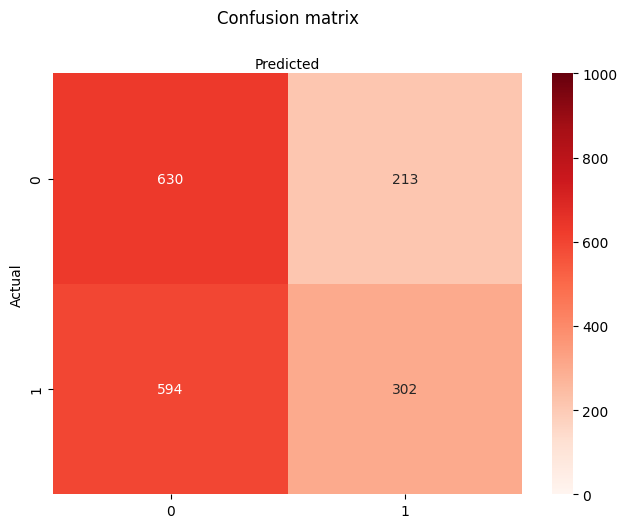

In [75]:
modelDest = LogisticRegression(random_state=16)
modelDest.fit(XDest_train, yDest_train)
y_predDest = modelDest.predict(XDest_test)

cnf_matrix_Dest = metrics.confusion_matrix(yDest_test, y_predDest)
cnf_matrix_Dest

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_Dest), annot=True, cmap="Reds" ,fmt='g',vmin=0, vmax=1000)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

target_names = ['Not Transported', 'Transported']
print(classification_report(yDest_test, y_predDest, target_names=target_names))

## Luxury Category

The luxury category was also a high performer. 88% recall on not transported, 81% precision on transported.

                 precision    recall  f1-score   support

Not Transported       0.65      0.87      0.74       836
    Transported       0.83      0.56      0.67       903

       accuracy                           0.71      1739
      macro avg       0.74      0.72      0.71      1739
   weighted avg       0.74      0.71      0.71      1739



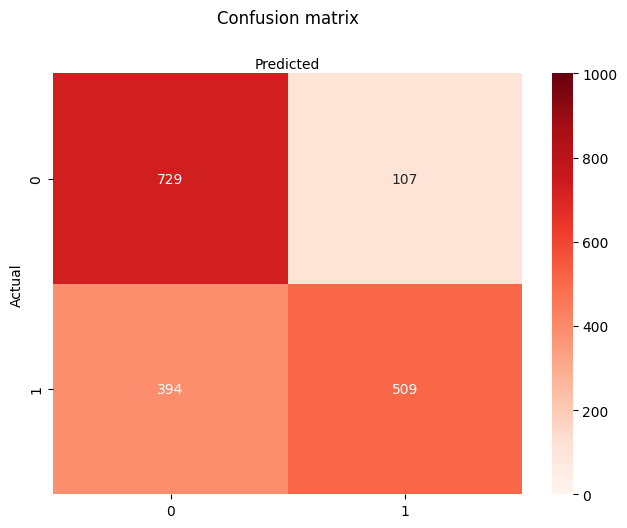

In [76]:
modelLuxury = LogisticRegression(random_state=16)
modelLuxury.fit(XLuxury_train, yLuxury_train)
y_predLuxury = modelLuxury.predict(XLuxury_test)

cnf_matrix_Luxury = metrics.confusion_matrix(yLuxury_test, y_predLuxury)
cnf_matrix_Luxury

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_Luxury), annot=True, cmap="Reds" ,fmt='g',vmin=0, vmax=1000)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

target_names = ['Not Transported', 'Transported']
print(classification_report(yLuxury_test, y_predLuxury, target_names=target_names))

# Deck Category

Finally the Deck category had some slightly above average performance. 61% accuracy over all.

                 precision    recall  f1-score   support

Not Transported       0.57      0.74      0.65       876
    Transported       0.62      0.44      0.51       863

       accuracy                           0.59      1739
      macro avg       0.60      0.59      0.58      1739
   weighted avg       0.60      0.59      0.58      1739



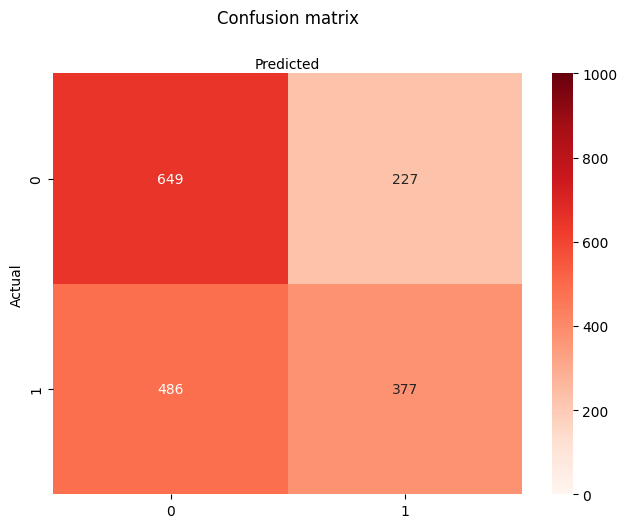

In [77]:
modelDeck = LogisticRegression(random_state=16)
modelDeck.fit(XDeck_train, yDeck_train)
y_predDeck = modelDeck.predict(XDeck_test)

cnf_matrix_Deck = metrics.confusion_matrix(yDeck_test, y_predDeck)
cnf_matrix_Deck

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_Deck), annot=True, cmap="Reds" ,fmt='g',vmin=0, vmax=1000)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

target_names = ['Not Transported', 'Transported']
print(classification_report(yDeck_test, y_predDeck, target_names=target_names))

## Bonus Round Spending and luxury Category

After using the broad categories the eek out a bit of information I combined the two better performing categories of Luxury and spending and got a fairly interesting result. A 78% overall accuracy, precision and recall.


                 precision    recall  f1-score   support

Not Transported       0.77      0.77      0.77       855
    Transported       0.78      0.77      0.78       884

       accuracy                           0.77      1739
      macro avg       0.77      0.77      0.77      1739
   weighted avg       0.77      0.77      0.77      1739



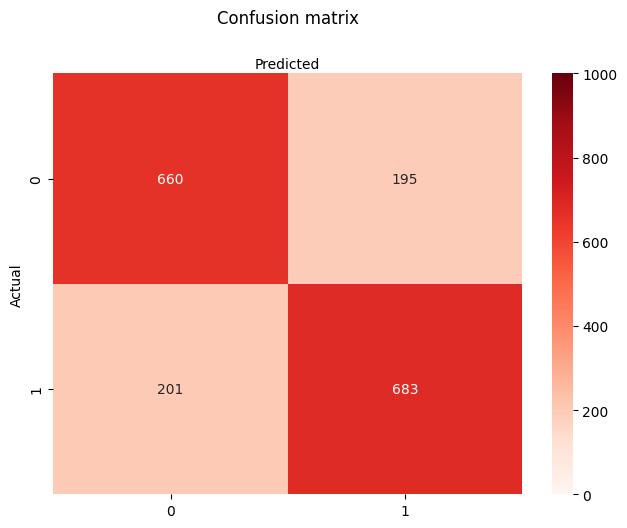

In [78]:
XSpendLux=train[['RoomService','FoodCourt' ,'ShoppingMall','Spa','VRDeck','CryoSleep_True','VIP_True']]
XSpendLux_train, XSpendLux_test, ySpendLux_train, ySpendLux_test = train_test_split(XSpendLux, y, test_size=0.2)

modelSpendLux = LogisticRegression(random_state=16)
modelSpendLux.fit(XSpendLux_train, ySpendLux_train)
y_predSpendLux = modelSpendLux.predict(XSpendLux_test)

cnf_matrix_SpendLux = metrics.confusion_matrix(ySpendLux_test, y_predSpendLux)
cnf_matrix_SpendLux

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_SpendLux), annot=True, cmap="Reds" ,fmt='g',vmin=0, vmax=1000)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

target_names = ['Not Transported', 'Transported']
print(classification_report(ySpendLux_test, y_predSpendLux, target_names=target_names))

# Conclusion of Logistic Regression

Based on the two high performing categories of Luxury, Spending, and the combination of the two it would lead me to believe that Wealth was very influencial on whether or not passenger was transported.